In [100]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

In [159]:
start_date = '2019-01-01'
end_date = '2022-01-01'

In [160]:
def RSIcalc(asset): #names
    df = yf.download(asset,start=start_date, end = end_date)
    df['MA200'] = df['Adj Close'].rolling(window=200).mean()
    df['Price Change'] = df['Adj Close'].pct_change()
    df['Upmove'] = df['Price Change'].apply(lambda x: x if x>0 else 0)
    df['Downmove'] = df['Price Change'].apply(lambda x: abs(x) if x<0 else 0)
    df['Avg Up'] = df["Upmove"].ewm(span=19).mean()
    df['Avg Down'] = df["Downmove"].ewm(span=19).mean()
    df = df.dropna()
    df['RS'] = (df['Avg Up']/df['Avg Down'])
    df['RSI']= df['RS'].apply(lambda x: 100-(100/(x+1)))
    df.loc[(df['Adj Close'] > df['MA200']) & (df['RSI']<50), 'Buy'] = 'Yes'
    df.loc[(df['Adj Close'] < df['MA200']) | (df['RSI']>50), 'Buy'] = 'No'
    return df

In [161]:
def getSignals(df):
    Buying_dates = []
    Selling_dates =[]
    
    for i in range(len(df)):
        if "Yes" in df['Buy'].iloc[i]:
            Buying_dates.append(df.iloc[i+1].name)
            for j in range(1,11):
                if df['RSI'].iloc[i + j] > 60:
                    Selling_dates.append(df.iloc[i+j+1].name)
                    break
                elif j==10:
                    Selling_dates.append(df.iloc[i+j+1].name)
            
                    
    return Buying_dates, Selling_dates    

## VARIOS ACTIVOS

[*********************100%***********************]  1 of 1 completed


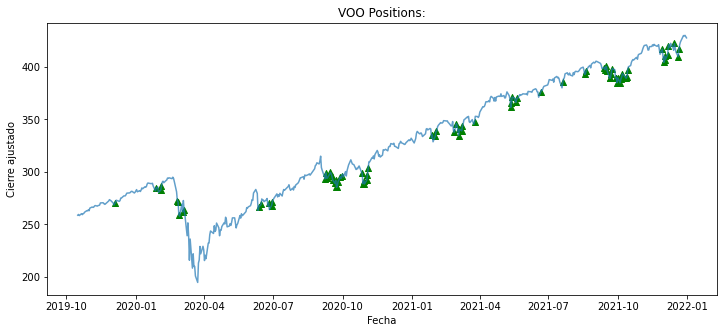

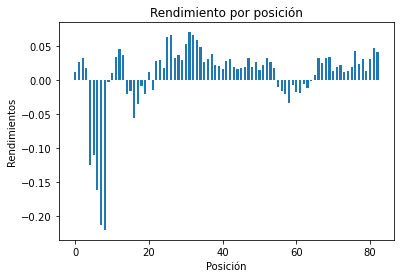

,Rendimientos,Utilidad,Monto
0,0.012123,0.009623,1009622.881
1,0.027117,0.024617,1034477.198
2,0.032579,0.030079,1065593.656
3,0.017579,0.015079,1081661.458
4,-0.125113,-0.127613,943627.012
...,...,...,...
78,0.030877,0.028377,1182308.770
79,0.012600,0.010100,1194250.161
80,0.030908,0.028408,1228175.876
81,0.047426,0.044926,1283352.886


'Victorias: 0.723'

'Balance: 1333803.98'

'Utilidad: 0.2'

In [184]:
# Elegir activo:
stock = 'VOO'

# Generar dataframe y calcular señales de compra:
frame = RSIcalc(stock)
Buy, Sell = getSignals(frame)

# Calcular retornos de estrategia
Profits = (frame.loc[Sell].Open.values - frame.loc[Buy].Open.values)/(frame.loc[Buy].Open.values)

# Delimitar costos de mercado y capital inicial
Comisiones = 0.0025
capital = 1000000

# Generar dataframe de retornos y utilidades
dfr = pd.DataFrame()
dfr['Rendimientos'] = Profits
dfr['Utilidad'] = dfr['Rendimientos']-Comisiones

# Generar columna de MONTO e INTERÉS COMPUESTO
Monto = [capital]

for i in range(len(dfr)):
    valor = Monto[-1]*(1+dfr['Utilidad'][i])
    Monto.append(valor)

    # se borra capital inicial de la lista de montos
del Monto[0]
dfr['Monto'] = np.round(Monto,3)

# Graficamos cierre de activo con fechas de compra:
plt.figure(figsize=(12,5))
plt.scatter(frame.loc[Buy].index , frame.loc[Buy]['Adj Close'], marker='^',c='g')
plt.plot(frame['Adj Close'], alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Cierre ajustado')
plt.title(str(stock)+ ' Positions:')
plt.show()

# Graficamos retorno generado por número de posición:
plt.bar(dfr.index, dfr.Rendimientos,width=0.6)
plt.xlabel("Posición")
plt.ylabel("Rendimientos")
plt.title("Rendimiento por posición")
plt.show()

# Calculamos el número de victorias en la estrategia:
wins = [i for i in Profits if i > 0]
wins = len(wins)/len(Profits)

# Calculamos utilidad final DESPUÉS DE IMPUESTOS
impuestos = 0.1
    
    # Encontramos monto final
ultimo = dfr[['Monto']].iloc[-1]
    
    # Restamos impuestos
ultimo_VOO = ultimo * (1-impuestos)
    
    # Lo convertimos en tasa comparado al capital inicial
utilidad_VOO = (ultimo_VOO - capital) / capital
    
# Mandamos todo a proyectar en la misma celda
display(dfr, 
        'Victorias: '+str(np.round(wins,3)),
        'Balance: '+str(np.round(ultimo,3)[0]),
        'Utilidad: ' +str(np.round(utilidad_VOO,3)[0]))

[*********************100%***********************]  1 of 1 completed


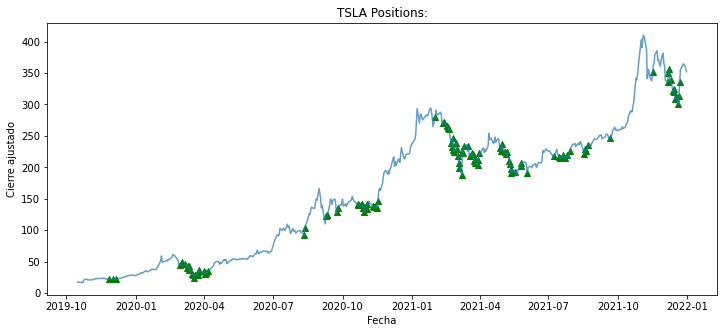

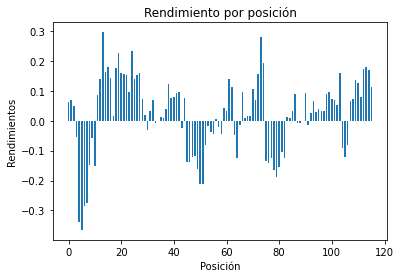

,Rendimientos,Utilidad,Monto
0,0.062696,0.060196,1060196.338
1,0.068245,0.065745,1129899.358
2,0.050388,0.047888,1184008.169
3,-0.055106,-0.057606,1115802.709
4,-0.339904,-0.342404,733747.592
...,...,...,...
111,0.079608,0.077108,1593519.205
112,0.173705,0.171205,1866337.483
113,0.178950,0.176450,2195653.200
114,0.171017,0.168517,2565657.441


'Victorias: 0.638'

'Balance: 2561593.271'

'Utilidad: 1.562'

In [185]:
# Elegir activo:
stock = 'TSLA'

# Generar dataframe y calcular señales de compra:
frame = RSIcalc(stock)
Buy, Sell = getSignals(frame)

# Calcular retornos de estrategia
Profits = (frame.loc[Sell].Open.values - frame.loc[Buy].Open.values)/(frame.loc[Buy].Open.values)

# Delimitar costos de mercado y capital inicial
Comisiones = 0.0025
capital = 1000000

# Generar dataframe de retornos y utilidades
dfr = pd.DataFrame()
dfr['Rendimientos'] = Profits
dfr['Utilidad'] = dfr['Rendimientos']-Comisiones

# Generar columna de MONTO e INTERÉS COMPUESTO
Monto = [capital]

for i in range(len(dfr)):
    valor = Monto[-1]*(1+dfr['Utilidad'][i])
    Monto.append(valor)

    # se borra capital inicial de la lista de montos
del Monto[0]
dfr['Monto'] = np.round(Monto,3)

# Graficamos cierre de activo con fechas de compra:
plt.figure(figsize=(12,5))
plt.scatter(frame.loc[Buy].index , frame.loc[Buy]['Adj Close'], marker='^',c='g')
plt.plot(frame['Adj Close'], alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Cierre ajustado')
plt.title(str(stock)+ ' Positions:')
plt.show()

# Graficamos retorno generado por número de posición:
plt.bar(dfr.index, dfr.Rendimientos,width=0.6)
plt.xlabel("Posición")
plt.ylabel("Rendimientos")
plt.title("Rendimiento por posición")
plt.show()

# Calculamos el número de victorias en la estrategia:
wins = [i for i in Profits if i > 0]
wins = len(wins)/len(Profits)

# Calculamos utilidad final DESPUÉS DE IMPUESTOS
impuestos = 0.1
    
    # Encontramos monto final
ultimo = dfr[['Monto']].iloc[-1]
    
    # Restamos impuestos
ultimo_TSLA = ultimo * (1-impuestos)
    
    # Lo convertimos en tasa comparado al capital inicial
utilidad_TSLA = (ultimo_TSLA - capital) / capital
    
# Mandamos todo a proyectar en la misma celda
display(dfr, 
        'Victorias: '+str(np.round(wins,3)),
        'Balance: '+str(np.round(ultimo_TSLA,3)[0]),
        'Utilidad: ' +str(np.round(utilidad_TSLA,3)[0]))

[*********************100%***********************]  1 of 1 completed


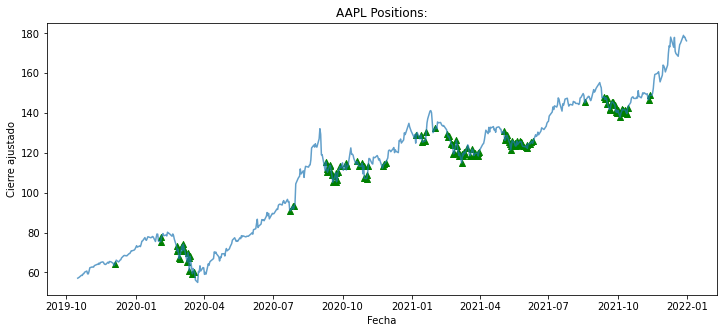

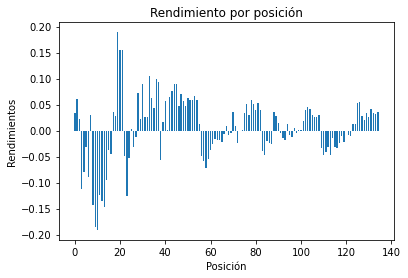

,Rendimientos,Utilidad,Monto
0,0.034205,0.031705,1031705.357
1,0.060040,0.057540,1091069.168
2,0.023025,0.020525,1113463.353
3,-0.112730,-0.115230,985159.387
4,-0.079116,-0.081616,904754.499
...,...,...,...
130,0.026391,0.023891,978451.305
131,0.040852,0.038352,1015977.232
132,0.034480,0.031980,1048468.478
133,0.031888,0.029388,1079280.611


'Victorias: 0.563'

'Balance: 1003477.53'

'Utilidad: 0.003'

In [186]:
stock = 'AAPL'

# Generar dataframe y calcular señales de compra:
frame = RSIcalc(stock)
Buy, Sell = getSignals(frame)

# Calcular retornos de estrategia
Profits = (frame.loc[Sell].Open.values - frame.loc[Buy].Open.values)/(frame.loc[Buy].Open.values)

# Delimitar costos de mercado y capital inicial
Comisiones = 0.0025
capital = 1000000

# Generar dataframe de retornos y utilidades
dfr = pd.DataFrame()
dfr['Rendimientos'] = Profits
dfr['Utilidad'] = dfr['Rendimientos']-Comisiones

# Generar columna de MONTO e INTERÉS COMPUESTO
Monto = [capital]

for i in range(len(dfr)):
    valor = Monto[-1]*(1+dfr['Utilidad'][i])
    Monto.append(valor)

    # se borra capital inicial de la lista de montos
del Monto[0]
dfr['Monto'] = np.round(Monto,3)

# Graficamos cierre de activo con fechas de compra:
plt.figure(figsize=(12,5))
plt.scatter(frame.loc[Buy].index , frame.loc[Buy]['Adj Close'], marker='^',c='g')
plt.plot(frame['Adj Close'], alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Cierre ajustado')
plt.title(str(stock)+ ' Positions:')
plt.show()

# Graficamos retorno generado por número de posición:
plt.bar(dfr.index, dfr.Rendimientos,width=0.6)
plt.xlabel("Posición")
plt.ylabel("Rendimientos")
plt.title("Rendimiento por posición")
plt.show()

# Calculamos el número de victorias en la estrategia:
wins = [i for i in Profits if i > 0]
wins = len(wins)/len(Profits)

# Calculamos utilidad final DESPUÉS DE IMPUESTOS
impuestos = 0.1
    
    # Encontramos monto final
ultimo = dfr[['Monto']].iloc[-1]
    
    # Restamos impuestos
ultimo_AAPL = ultimo * (1-impuestos)
    
    # Lo convertimos en tasa comparado al capital inicial
utilidad_AAPL = (ultimo_AAPL - capital) / capital
    
# Mandamos todo a proyectar en la misma celda
display(dfr, 
        'Victorias: '+str(np.round(wins,3)),
        'Balance: '+str(np.round(ultimo_AAPL,3)[0]),
        'Utilidad: ' +str(np.round(utilidad_AAPL,3)[0]))

[*********************100%***********************]  1 of 1 completed


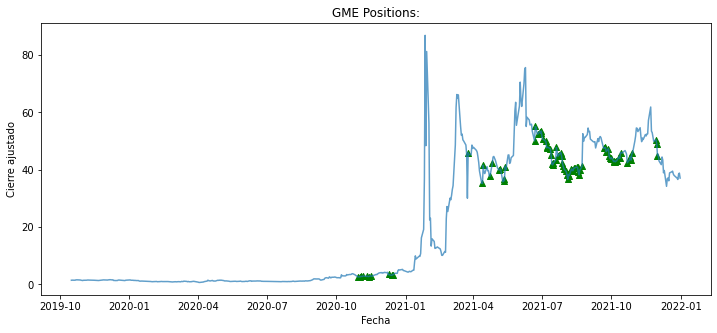

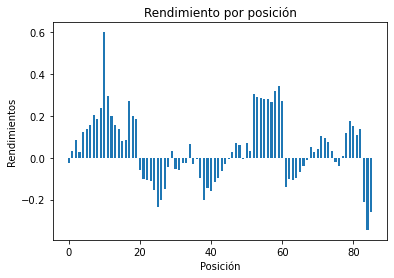

,Rendimientos,Utilidad,Monto
0,-0.024055,-0.026555,9.734450e+05
1,0.031423,0.028923,1.001600e+06
2,0.083721,0.081221,1.082951e+06
3,0.029281,0.026781,1.111954e+06
4,0.121739,0.119239,1.244542e+06
...,...,...,...
81,0.107500,0.105000,2.674326e+07
82,0.138102,0.135602,3.036970e+07
83,-0.214069,-0.216569,2.379258e+07
84,-0.345327,-0.347827,1.551687e+07


'Victorias: 0.558'

'Balance: 10292599.084'

'Utilidad: 9.293'

In [187]:
stock = 'GME'

# Generar dataframe y calcular señales de compra:
frame = RSIcalc(stock)
Buy, Sell = getSignals(frame)

# Calcular retornos de estrategia
Profits = (frame.loc[Sell].Open.values - frame.loc[Buy].Open.values)/(frame.loc[Buy].Open.values)

# Delimitar costos de mercado y capital inicial
Comisiones = 0.0025
capital = 1000000

# Generar dataframe de retornos y utilidades
dfr = pd.DataFrame()
dfr['Rendimientos'] = Profits
dfr['Utilidad'] = dfr['Rendimientos']-Comisiones

# Generar columna de MONTO e INTERÉS COMPUESTO
Monto = [capital]

for i in range(len(dfr)):
    valor = Monto[-1]*(1+dfr['Utilidad'][i])
    Monto.append(valor)

    # se borra capital inicial de la lista de montos
del Monto[0]
dfr['Monto'] = np.round(Monto,3)

# Graficamos cierre de activo con fechas de compra:
plt.figure(figsize=(12,5))
plt.scatter(frame.loc[Buy].index , frame.loc[Buy]['Adj Close'], marker='^',c='g')
plt.plot(frame['Adj Close'], alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Cierre ajustado')
plt.title(str(stock)+ ' Positions:')
plt.show()

# Graficamos retorno generado por número de posición:
plt.bar(dfr.index, dfr.Rendimientos,width=0.6)
plt.xlabel("Posición")
plt.ylabel("Rendimientos")
plt.title("Rendimiento por posición")
plt.show()

# Calculamos el número de victorias en la estrategia:
wins = [i for i in Profits if i > 0]
wins = len(wins)/len(Profits)

# Calculamos utilidad final DESPUÉS DE IMPUESTOS
impuestos = 0.1
    
    # Encontramos monto final
ultimo = dfr[['Monto']].iloc[-1]
    
    # Restamos impuestos
ultimo_GME = ultimo * (1-impuestos)
    
    # Lo convertimos en tasa comparado al capital inicial
utilidad_GME = (ultimo_GME - capital) / capital
    
# Mandamos todo a proyectar en la misma celda
display(dfr, 
        'Victorias: '+str(np.round(wins,3)),
        'Balance: '+str(np.round(ultimo_GME,3)[0]),
        'Utilidad: '+str(np.round(utilidad_GME,3)[0]))

In [188]:
cap_total = capital*4
suma_montos = ultimo_VOO + ultimo_TSLA + ultimo_AAPL + ultimo_GME
utilidad_total = (suma_montos - cap_total) / cap_total
utilidad_total

Monto    2.764523
dtype: float64